# Construct Cancer-type Specific Container
In this notebook, I'd like to explore if it is possible to train a GCN on multi-omics data from a specific cancer type. This can be done in two ways, either patient-specific or averaged.
In the patient-specific way, each column of the feature matrix consists of 3 values per patient for expression, methylation and mutation scores. Maybe its possible to extend the graph convolutions to 3D.
In the other setting, we have three values per gene only, corresponding to the average mutation frequency, average differential DNA methlyation at promotors and average log2 fold change gene expression.

In [1]:
# classics
import pandas as pd
import numpy as np
from sklearn import preprocessing

# dimensionality reductions/embeddings
import umap
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Own code
import os, sys
import preprocessing_utils as utils
sys.path.append(os.path.abspath('../../GCN'))
import gcnIO, gcnPreprocessing

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn
plt.rc('font', family='Times New Roman')

%matplotlib inline

## Parameters

* `patient_specific`: Whether or not to output a 3D feature tensor with genes in the rows and columns corresponding to the patients and the third dimension corresponding to the 3 values for mutations, methylation and expression similar to channels in a image setting or whether to  only have 3 values per gene.
* `cancer_type`: The cancer type in question denoted by the TCGA study names
* `mutation_only`: If true, only use the mutation data, otherwise use all data
* `reference_container`: Which multi-omics reference container to use

In [2]:
patient_specific = True
cancer_type = 'BRCA'
mutation_only = False
reference_container = '../../data/pancancer/all_omics_final_CPDB/CPDB_multiomics.h5'
network_name = 'CPDB'
label_source = 'all'

### Get Multi-Omics Data
Let's start by reading $gene \times sample$ matrices for all omics data sets.

In [3]:
submitter_project_mapping = pd.read_json('../../data/pancancer/TCGA/mutation/download_new/cases_all_cancers.2018-11-26.json')
submitter_project_mapping.head()
submitter_project_mapping['Cancer_Type'] = [dict(i)['project_id'] for i in submitter_project_mapping.project]
submitter_project_mapping = submitter_project_mapping[['submitter_id', 'Cancer_Type']].set_index('submitter_id')
submitter_project_mapping['Cancer_Type'] = [i[1] for i in submitter_project_mapping.Cancer_Type.str.split('-')]
trim_to_submitter = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode until patient

In [4]:
mutfreqs_patients = pd.read_hdf('../../data/pancancer/TCGA/mutation/mutation_frequencies_lengthnormalized.h5', 'snv_cna_sample_matrix').T
mutfreqs_patients.index = mutfreqs_patients.index.map(trim_to_submitter)
mutfreqs_patients = mutfreqs_patients.join(submitter_project_mapping)
mutation_features = mutfreqs_patients[mutfreqs_patients.Cancer_Type == cancer_type].T.drop('Cancer_Type', axis=0)

In [5]:
meth_samples = pd.read_hdf('../../data/pancancer/TCGA/methylation/sample_matrix_foldchanges.h5', 'methylation_sample_matrix').T
meth_samples['Cancer_Type'] = [i[1] for i in meth_samples.index.str.split('|')]
meth_features = meth_samples[meth_samples.Cancer_Type.str.upper() == cancer_type].T.drop('Cancer_Type', axis=0)
meth_features.columns = [i.split('|')[0].strip() for i in meth_features.columns] # remove everything but the TCGA barcode
meth_features.columns = meth_features.columns.map(trim_to_submitter) # remove parts of barcode that no longer describe the patient (submitter)

In [6]:
ge_samples = pd.read_hdf('../../data/pancancer/TCGA/expression/sample_matrix_fc_gtex.h5').T
ge_samples.index = ge_samples.index.map(trim_to_submitter)
ge_samples = ge_samples.join(submitter_project_mapping)
expr_features = ge_samples[ge_samples.Cancer_Type == cancer_type].T.drop('Cancer_Type', axis=0)

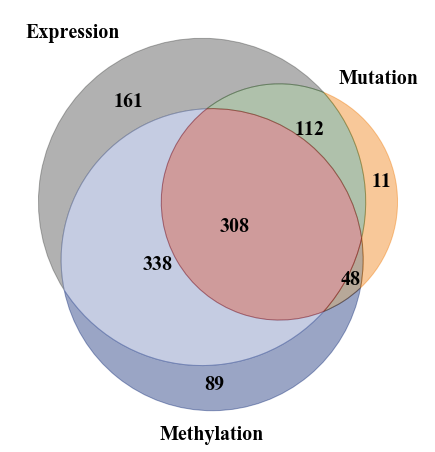

In [7]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(expr_features.columns), set(mutation_features.columns), set(meth_features.columns)],
                          set_labels=["Expression", "Mutation", "Methylation"])
if not v.get_patch_by_id('10') is None:
    v.get_patch_by_id('10').set_color('#3d3e3d')
    v.get_label_by_id('10').set_fontsize(20)
if not v.get_patch_by_id('11') is None:
    v.get_patch_by_id('11').set_color('#37652d')
    v.get_label_by_id('11').set_fontsize(20)
v.get_patch_by_id('011').set_color('#4d2600')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
if not v.get_patch_by_id('01') is None:
    v.get_patch_by_id('01').set_color('#ee7600')
    v.get_label_by_id('01').set_fontsize(20)
if not v.get_patch_by_id('111') is None and not v.get_patch_by_id('101') is None:
    v.get_label_by_id('111').set_fontsize(20)
    v.get_label_by_id('101').set_fontsize(20)
    v.get_patch_by_id('111').set_color('#890707')
    v.get_patch_by_id('101').set_color('#6E80B7')
if not v.get_patch_by_id('011') is None:
    v.get_label_by_id('011').set_fontsize(20)
if not v.get_patch_by_id('001') is None:
    v.get_patch_by_id('001').set_color('#031F6F')
    v.get_label_by_id('001').set_fontsize(20)

In [8]:
common_samples = list(set(expr_features.columns).intersection(mutation_features.columns).intersection(meth_features.columns))

### Adjust to PPI Nodes & Compute 3D Feature Tensor

In [9]:
data = gcnIO.load_hdf_data(reference_container)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data

In [10]:
scaler = preprocessing.MinMaxScaler()
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('Name')

all_omics_normed = []
all_omics_raw = []
for feat in [mutation_features, meth_features, expr_features]:
    feat_avg_samples = feat.astype(np.float32).groupby(level=0, axis=1).mean() # average same patient's samples
    feat_ppiindex = feat_avg_samples.reindex(nodes.index, fill_value=0) # reindex to match with PPI nodes
    feat_common = feat_ppiindex[common_samples]
    feat_normed = scaler.fit_transform(feat_common) # normalize
    all_omics_normed.append(feat_normed)
    all_omics_raw.append(feat_common.values)
    print (feat_normed.shape, feat_common.shape)

/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(13627, 308) (13627, 308)


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(13627, 308) (13627, 308)
(13627, 308) (13627, 308)


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
multiomics_features_3d = np.array(all_omics_normed)
multiomics_features_3d = np.transpose(multiomics_features_3d, (1, 2, 0))
multiomics_features_3d_raw = np.array(all_omics_raw)
multiomics_features_3d_raw = np.transpose(multiomics_features_3d_raw, (1, 2, 0))
multiomics_features_3d.shape

(13627, 308, 3)

### Collect labels

In [12]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

positives = utils.get_positive_labels(nodes,
                                      strategy=label_source,
                                      cancer_type=cancer_type,
                                      remove_blood_cancer_genes=False,
                                      verbose=True
                                     )

Collected 1021 cancer genes with strategy all


In [13]:
negatives = utils.get_negative_labels(nodes,
                                      positives,
                                      pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1]),
                                      min_degree=1,
                                      verbose=True
                                     )

13627 genes are in network
12606 genes are in network but not in positives (known cancer genes from NCG)
12587 genes are also not in OMIM cancer genes
2334 genes are in network but not in oncogenes and not in OMIM
2334 genes are also not in COSMIC cancer gene census
2334 genes are also not in COSMIC mutated genes
2331 genes are also not in KEGG cancer pathways
2178 genes are also not in NCG candidate cancer genes
2178 genes have a degree >= 1.


### Train & Test Splits

In [14]:
y = nodes.Name.isin(positives).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(positives)

y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), y_val.sum(), val_mask.sum()

(689, 2159, 255, 800, 77, 240)

### Construct Container with Cancertype-Specific Features

In [15]:
fname = '../../data/cancer_specific/{}_{}_{}_BRCAlabels.h5'.format(cancer_type, 'patients' if patient_specific else 'avg', 'mut' if mutation_only else 'all')

if mutation_only:
    final_features_normed = all_omics_normed[0]
    final_features_raw = all_omics_raw[0]
else:
    final_features_normed = multiomics_features_3d
    final_features_raw = multiomics_features_3d_raw

utils.write_hdf5_container(fname,
                           adj=adj,
                           F=final_features_normed,
                           node_names=node_names,
                           y_train=y_train, y_val=y_val, y_test=y_test,
                           train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
                           feature_names=common_samples,
                           features_raw=final_features_raw.astype(np.float32)
                          )

Container written to ../../data/cancer_specific/BRCA_patients_all_BRCAlabels.h5


## Compute Embedding

In [16]:
type_of_omics = 0

if type_of_omics == 0:
    omics_name = 'Mutation Frequencies'
elif type_of_omics == 1:
    omics_name = 'Differential Promoter DNA Methylation'
else:
    omics_name = 'Differential Gene Expression'

features_all = pd.DataFrame(multiomics_features_3d[:, :, type_of_omics], columns=common_samples, index=node_names[:, 1])
#features_all = pd.DataFrame(all_omics_normed[type_of_omics], columns=common_samples, index=node_names[:, 1])

reducer = umap.UMAP(n_components=2)
emb = reducer.fit_transform(features_all.T)
emb_df = pd.DataFrame(emb, index=features_all.columns, columns=['PC1', 'PC2'])

clu = KMeans(n_clusters=3)
clustering = clu.fit_predict(emb)
emb_df['My Clusters'] =  pd.Categorical.from_codes(clustering, categories=['A', 'B', 'C'])

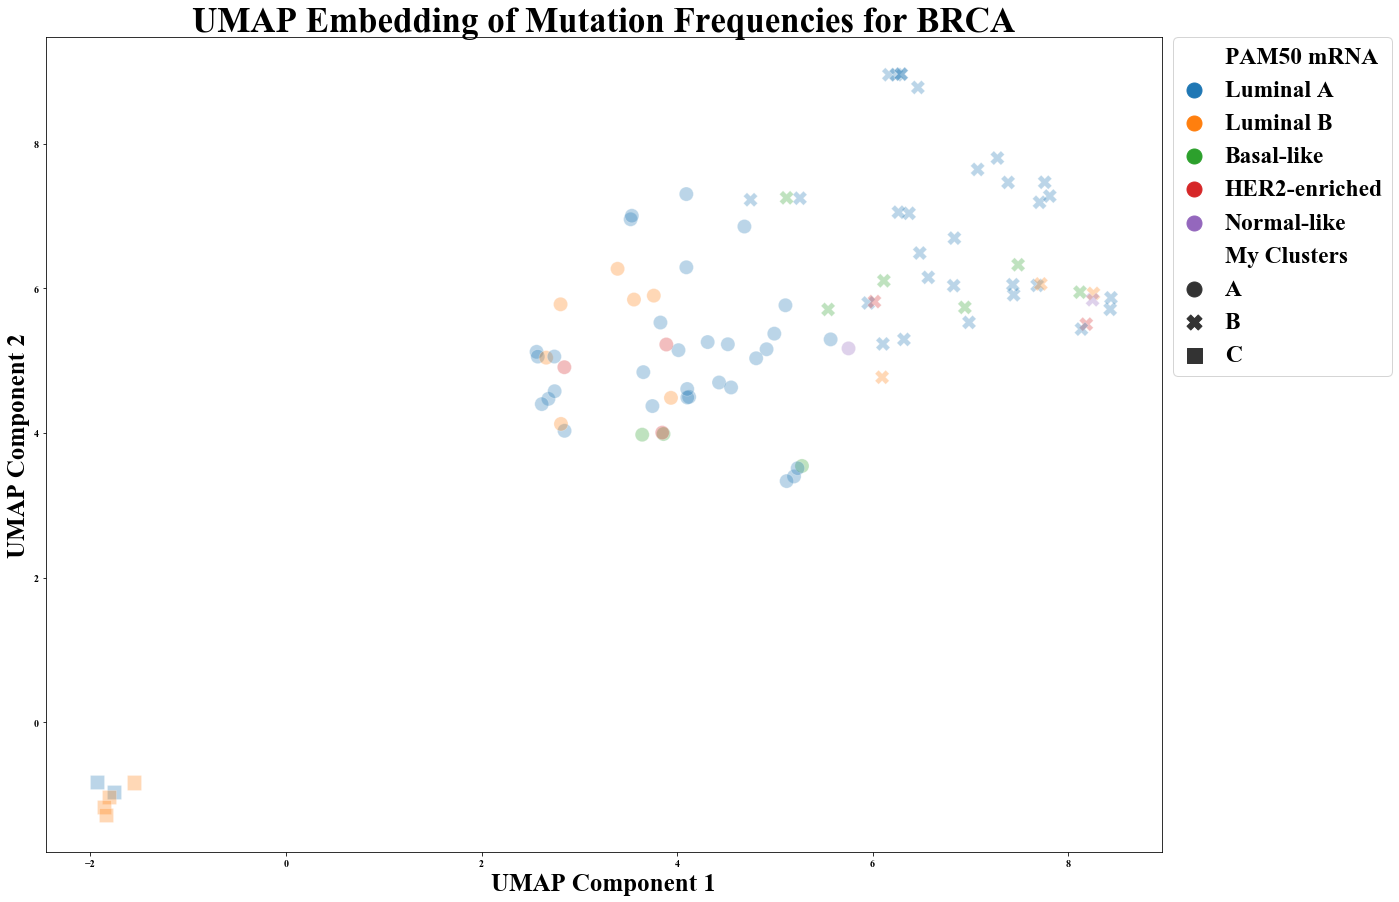

In [17]:
clinical = pd.read_csv('../../data/cancer_specific/BRCA_subtypes/BRCA_original_clinical.csv', sep='\t', header=1)
clinical.set_index('Complete TCGA ID', inplace=True)
#clinical = pd.read_csv('../../data/cancer_specific/BRCA_subtypes/BRCA_clinical_sheet.tsv', sep='\t').set_index('submitter_id')
emb_df['NINJ2'] = features_all[features_all.index == 'NINJ2'].values.reshape(-1)
emb_df['PDSS2'] = features_all[features_all.index == 'PDSS2'].values.reshape(-1)
emb_df['BRCA2'] = features_all[features_all.index == 'BRCA2'].values.reshape(-1)
emb_df['TSS'] = [i[1] for i in emb_df.index.str.split('-')]
emb_df['Participant'] = [i[2] for i in emb_df.index.str.split('-')]
embedding_with_clinical = emb_df.join(clinical, how='inner')
fig = plt.figure(figsize=(20, 15))
g = sns.scatterplot(data=embedding_with_clinical, x='PC1', y='PC2', hue='PAM50 mRNA', style='My Clusters',
                    alpha=0.3, s=200)#, palette=sns.color_palette("Set2", n_colors=10)+sns.color_palette("bright", n_colors=10))
g.set_xlabel('UMAP Component 1', fontsize=25)
g.set_ylabel('UMAP Component 2', fontsize=25)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
#legend.texts[17].set_text(r"$\bf{Type}$")
g.set_title('UMAP Embedding of {} for {}'.format(omics_name, cancer_type), fontsize=35)
fig.savefig('../../data/cancer_specific/{}_{}.png'.format(cancer_type, omics_name.replace(' ', '_')), bbox_inches="tight", dpi=300)

### ANOVA Clustering Test
Let's run an ANOVA to see which genes are responsible for the formation of the clusters.

In [37]:
f_T = features_all.T
F, p = stats.f_oneway(f_T.loc[emb_df['My Clusters'] =='A'],
                      #f_T.loc[emb_df['My Clusters'] =='B'],
                      f_T.loc[emb_df['My Clusters'] =='C']
                     )
nodes['F_Score_Clustering'] = F
nodes.sort_values(by='F_Score_Clustering', ascending=False).head(10)

,ID,Name,F_Score_Clustering
684,ENSG00000116824,CD2,869.441600
8610,ENSG00000009307,CSDE1,845.590743
9874,ENSG00000198765,SYCP1,845.127249
215,ENSG00000134259,NGF,844.845551
417,ENSG00000117528,ABCD3,844.808164
6589,ENSG00000122417,ODF2L,844.645346
1817,ENSG00000065135,GNAI3,829.384785
10377,ENSG00000198758,EPS8L3,829.384785
2899,ENSG00000137947,GTF2B,829.384785
3834,ENSG00000142875,PRKACB,829.384785


### PCA of five dimension
Finally, do a PCA and plot the first 5 components against each other

/home/sasse/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sasse/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


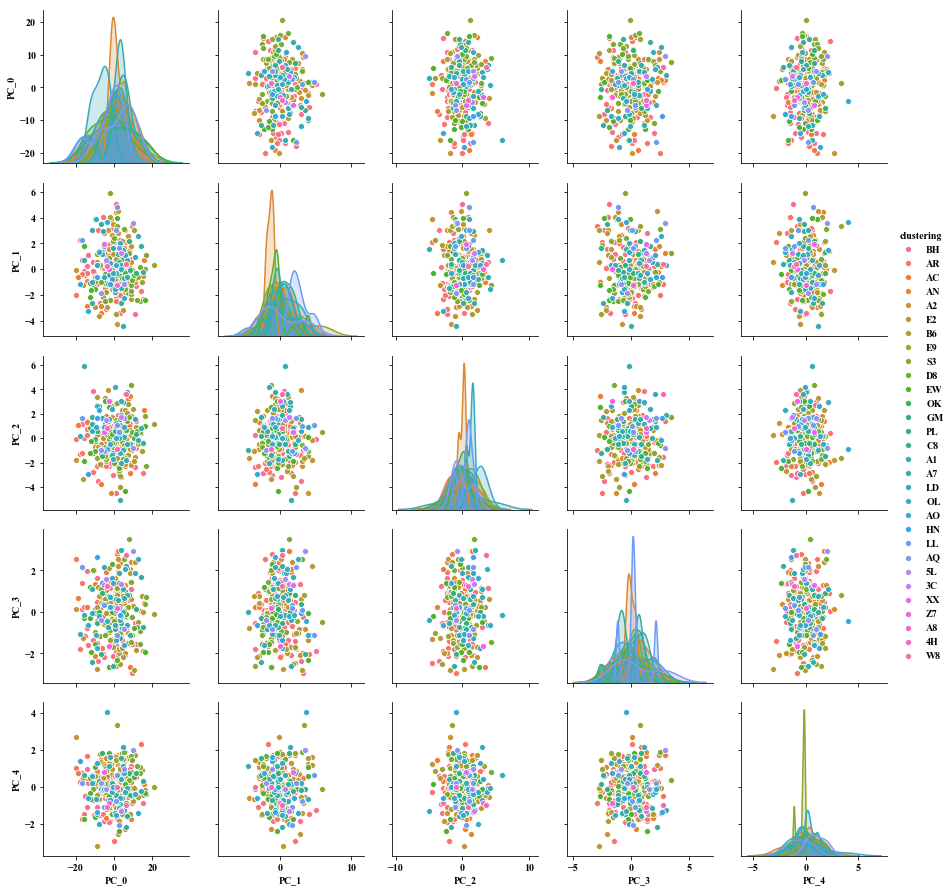

In [29]:
pca_obj = PCA(n_components=5)
pca_emb = pca_obj.fit_transform(features_all.T)

pca_df = pd.DataFrame(pca_emb, index=emb_df.index, columns=['PC_{}'.format(i) for i in range(pca_obj.n_components)])
#pca_df['clustering'] = emb_df['My Clusters']
pca_df['clustering'] = emb_df['TSS']
sns.pairplot(pca_df, hue='clustering')